# Part 2: Soft Actor Critic
#### Project by Hanqing Li, Kumar Utkarsh, Richard Suhendra
### Goal:
Our goal is to implement Soft Actor Critic algorithms as in [1,2] and compare them to each other, as well as to the regular Actor Critic we learned in class.

[1] Haarnoja, T., Zhou, A., Abbeel, P., and Levine, S. Soft actor-critic: Off-policy maximum entropy
deep reinforcement learning with a stochastic actor. In International Conference on Machine
Learning (ICML), 2018c.

[2] T. Haarnoja, A. Zhou, K. Hartikainen, G. Tucker, S. Ha, J. Tan, V. Kumar, H. Zhu, A. Gupta, P. Abbeel, and
S. Levine. Soft actor-critic algorithms and applications. CoRR, abs/1812.05905, 2018.

### Installations and imports

In [1]:
!apt-get install -y \
    libgl1-mesa-dev \
    libgl1-mesa-glx \
    libglew-dev \
    libosmesa6-dev \
    software-properties-common

!apt-get install -y patchelf
!pip install free-mujoco-py
!pip install box2d-py

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libglew-dev is already the newest version (2.0.0-5).
libgl1-mesa-dev is already the newest version (20.0.8-0ubuntu1~18.04.1).
libgl1-mesa-glx is already the newest version (20.0.8-0ubuntu1~18.04.1).
libosmesa6-dev is already the newest version (20.0.8-0ubuntu1~18.04.1).
software-properties-common is already the newest version (0.96.24.32.18).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
patchelf is already the newest version (0.9-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Looking in indexe

In [2]:
import math
import random

import gym
import mujoco_py

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

from IPython.display import clear_output
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import display

%matplotlib inline

use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

# Auxillary Functions

### Experience Replay Buffer
Stack object used for storing past experiences and sampling from them

In [3]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)

### Gym Wrapper
Used to normalize actions to the range $[-1,1]$

In [4]:
class NormalizedActions(gym.ActionWrapper):
    def action(self, action):
        # rescale the action
        low, high = self.env.action_space.low, self.env.action_space.high
        scaled_action = low + (action + 1.0) * (high - low) / 2.0
        scaled_action = np.clip(scaled_action, low, high)
        return scaled_action

    def reverse_action(self, scaled_action):
        low, high = self.env.action_space.low, self.env.action_space.high
        action = (scaled_action - low) * 2.0 / (high - low) - 1.0
        return action

### Plotting function
For convenient update plotting

In [5]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()

# Network Models
### Weights
All weights are initialized using Xavier initialization (e.g scaled to size of input layer + output layer).

### ValueNetwork
Standard neural network for approximating Value Function.

### DoubleQNetwork
Two standard Q networks rolled into one net. Standard Q networks have overestimation bias, so our aim is to use two and take the minimum. In practice, that can also be written as two single neural networks, but this is done for convenience.

### Policy Network
The neural net takes in a state and returns a mean and standard deviation for a Gaussian. The Gaussian is then sampled and plugged into the $\tanh$ function to get an action. The evaluate method in the class additionally returns a log probability. 

In [6]:
def weights_init_(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight, gain=1)
        torch.nn.init.constant_(m.bias, 0)

class ValueNetwork(nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNetwork, self).__init__()
        
        self.linear1 = nn.Linear(state_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, 1)
        
        self.apply(weights_init_)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x
        
        
class DoubleQNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size):
        super(DoubleQNetwork, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs + num_actions, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)

        self.linear4 = nn.Linear(num_inputs + num_actions, hidden_size)
        self.linear5 = nn.Linear(hidden_size, hidden_size)
        self.linear6 = nn.Linear(hidden_size, 1)
        
        self.apply(weights_init_)
        
    def forward(self, state, action):
        xu = torch.cat([state, action], 1)
        x1 = F.relu(self.linear1(xu))
        x1 = F.relu(self.linear2(x1))
        x1 = self.linear3(x1)

        x2 = F.relu(self.linear4(xu))
        x2 = F.relu(self.linear5(x2))
        x2 = self.linear6(x2)
        return x1, x2
        
        
class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, log_std_min=-20, log_std_max=2):
        super(PolicyNetwork, self).__init__()
        
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        
        self.mean_linear = nn.Linear(hidden_size, num_actions)
        self.log_std_linear = nn.Linear(hidden_size, num_actions)
        
        self.apply(weights_init_)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        
        mean    = self.mean_linear(x)
        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        
        return mean, log_std
    
    def evaluate(self, state, epsilon=1e-6):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        
        normal = Normal(0, 1)
        z      = normal.sample()
        action = torch.tanh(mean+ std*z.to(device))
        log_prob = Normal(mean, std).log_prob(mean+ std*z.to(device)) - torch.log(1 - action.pow(2) + epsilon)
        log_prob = log_prob.sum(1, keepdim=True)
        return action, log_prob
        
    
    def get_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        mean, log_std = self.forward(state)
        std = log_std.exp()
        
        normal = Normal(0, 1)
        z      = normal.sample().to(device)
        action = torch.tanh(mean + std*z)
    
        action  = action.cpu()#.detach().cpu().numpy()
        return action[0]

# Soft Actor Critic
Soft Actor Critic is much similar to the regular Actor Critic framework, with the addition that it also seeks to maximize the entropy of the policy. The entropy terms allows for actions with slightly different Q values to have similar probabilities. Higher entropy in the policy also encourages exploration. We therefore have the modified objective:

$$J(\pi)=\sum_{t=0}^{T} \mathbb{E}_{\left(\mathbf{s}_{t}, \mathbf{a}_{t}\right) \sim \rho_{\pi}}\left[r\left(\mathbf{s}_{t}, \mathbf{a}_{t}\right)+\alpha \mathcal{H}\left(\pi\left(\cdot \mid \mathbf{s}_{t}\right)\right)\right]$$

where $\alpha$ is a parameter called temperature. In SAC [1], this is the only parameter that needs tuning. However, in SAC [2], they develop an algorithm to automatically learn the temperature. Essentially, that is the key difference between these two models, although in practice, other subtle changes are needed that requires two different pieces of code.

# SAC [1]
Here, we implement the algorithm as in SAC [1]. We make use of 4 neural nets, the DoubleQNetwork parameterized by $\theta$ for approximating the Q function, a PolicyNetwork ($\phi$) for approximating the policy, and two ValueNetworks ($\psi$ and $\bar{\psi}$), one for Value function itself and a delayed version to be used as a target. In practice, a seperate value function is not needed, but can help in convergence. The temperature $\alpha$ can be subsumed into the reward by scaling it like $\alpha^{-1}$ and is therefore omitted from the code for SAC [1].

In [7]:
env = NormalizedActions(gym.make('Walker2d-v2'))
#env = NormalizedActions(gym.make("BipedalWalker-v3"))
#env = NormalizedActions(gym.make('HalfCheetah-v2'))

action_dim = env.action_space.shape[0]
state_dim  = env.observation_space.shape[0]
hidden_dim = 256

value        = ValueNetwork(state_dim, hidden_dim).to(device)
value_target = ValueNetwork(state_dim, hidden_dim).to(device)

critic = DoubleQNetwork(state_dim, action_dim, hidden_dim).to(device)
policy = PolicyNetwork(state_dim, action_dim, hidden_dim).to(device)

for target_param, param in zip(value_target.parameters(), value.parameters()):
    target_param.data.copy_(param.data)

critic_lr = 3e-4
policy_lr = 3e-4
value_lr = 3e-4

critic_optimizer = optim.Adam(critic.parameters(), lr=critic_lr)
policy_optimizer = optim.Adam(policy.parameters(), lr=policy_lr)
value_optimizer  = optim.Adam(value.parameters(), lr=value_lr)

replay_buffer_size = 1000000
replay_buffer = ReplayBuffer(replay_buffer_size)

# Update [1] Function
For each update, we batch sample and attempt to minimize the following loss functions:

For the value function:
$$
J_{V}(\psi)=\mathbb{E}_{\mathbf{s}_{t} \sim \mathcal{D}}\left[\frac{1}{2}\left(V_{\psi}\left(\mathbf{s}_{t}\right)-\mathbb{E}_{\mathbf{a}_{t} \sim \pi_{\phi}}\left[Q_{\theta}\left(\mathbf{s}_{t}, \mathbf{a}_{t}\right)-\log \pi_{\phi}\left(\mathbf{a}_{t} \mid \mathbf{s}_{t}\right)\right]\right)^{2}\right]
$$
For the Q function:
$$J_{Q}(\theta)=\mathbb{E}_{\left(\mathbf{s}_{t}, \mathbf{a}_{t}\right) \sim \mathcal{D}}\left[\frac{1}{2}\left(Q_{\theta}\left(\mathbf{s}_{t}, \mathbf{a}_{t}\right)-\hat{Q}\left(\mathbf{s}_{t}, \mathbf{a}_{t}\right)\right)^{2}\right]$$
with
$$
\hat{Q}\left(\mathbf{s}_{t}, \mathbf{a}_{t}\right)=r\left(\mathbf{s}_{t}, \mathbf{a}_{t}\right)+\gamma \mathbb{E}_{\mathbf{s}_{t+1} \sim p}\left[V_{\bar{\psi}}\left(\mathbf{s}_{t+1}\right)\right]
$$
For the policy:
$$
J_{\pi}(\phi)=\mathbb{E}_{\mathbf{s}_{t} \sim \mathcal{D}, \epsilon_{t} \sim \mathcal{N}}\left[\log \pi_{\phi}\left(f_{\phi}\left(\epsilon_{t} ; \mathbf{s}_{t}\right) \mid \mathbf{s}_{t}\right)-Q_{\theta}\left(\mathbf{s}_{t}, f_{\phi}\left(\epsilon_{t} ; \mathbf{s}_{t}\right)\right)\right]
$$

We also use an exponentially moving Polyak average to do a soft update for the target value network at each step:
$$ \bar{\psi}_{t+1} = \tau\bar{\psi}_t+(1-\tau)\bar{\psi}_t$$

In [8]:
def update1(batch_size,gamma=0.99,soft_tau=1e-2,):
    
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = torch.FloatTensor(state).to(device)
    next_state = torch.FloatTensor(next_state).to(device)
    action     = torch.FloatTensor(action).to(device)
    reward     = torch.FloatTensor(reward).unsqueeze(1).to(device)
    done       = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(device)
    
    qf1, qf2 = critic(state, action)
    vf = value(state)
    pi, log_prob = policy.evaluate(state)

# Training Q Function
    vf_target = value_target(next_state)
    target_q_value = reward + (1 - done) * gamma * vf_target

    qf1_loss = F.mse_loss(qf1, target_q_value.detach())  
    qf2_loss = F.mse_loss(qf2, target_q_value.detach())
    qf_loss = qf1_loss + qf2_loss

    critic_optimizer.zero_grad()
    qf_loss.backward()
    critic_optimizer.step()

# Training Value Function  
    qf1_pi, qf2_pi = critic(state, pi)
    min_qf_pi = torch.min(qf1_pi, qf2_pi)
    target_value_func = min_qf_pi - log_prob
    value_loss = F.mse_loss(vf, target_value_func.detach())

    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()

# Training Policy Function
    policy_loss = (log_prob - min_qf_pi).mean()

    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()
    
    for target_param, param in zip(value_target.parameters(), value.parameters()):
        target_param.data.copy_(target_param.data * (1.0 - soft_tau) + param.data * soft_tau)

# Training Hyperparameters [1]

In [9]:
max_frames  = 150000
max_steps   = 1000
frame_idx   = 0
rewards     = []
batch_size  = 128
explore_before = 5000
plot_idx = 3000
reward_scale = 5  # essentially setting alpha=0.2

# Training Loop [1]

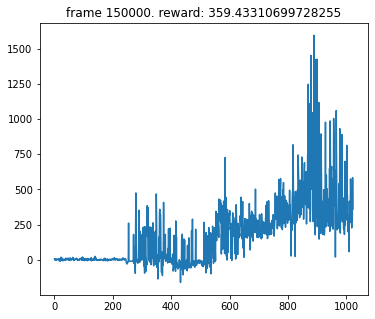

In [10]:
while frame_idx < max_frames:
    state = env.reset()
    episode_reward = 0
    
    for step in range(max_steps):
        if frame_idx > explore_before:
            action = policy.get_action(state).detach()
            next_state, reward, done, _ = env.step(action.numpy())
        else:
            action = env.action_space.sample()
            next_state, reward, done, _ = env.step(action)
        
        reward *= reward_scale # reward scaling

        replay_buffer.push(state, action, reward, next_state, done)
        
        state = next_state
        episode_reward += reward
        frame_idx += 1
        
        if len(replay_buffer) > batch_size:
            update1(batch_size)
        
        if frame_idx % plot_idx == 0:
            plot(frame_idx, rewards)
        
        if done:
            break
        
    rewards.append(episode_reward/reward_scale)

Above are the SAC1 results for Walker2d. Below are SAC1 results for BipedalWalker.

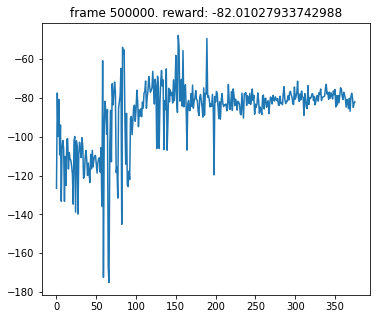

# SAC [2]
Here, we implement the algorithm as in SAC [2]. SAC [2] differs from SAC[1] in that we automatically learn the temperature $\alpha$. Here, we also make use of 3 neural nets: two DoubleQNetworks parameterized ($\theta$, $\bar{\theta}$), one for approximating the Q function and one delayed for use as a target, and a PolicyNetwork ($\phi$) for approximating the policy. We also update the temperature $\alpha$ using neural net methods.

In [11]:
env = NormalizedActions(gym.make('Walker2d-v2'))
#env = NormalizedActions(gym.make("BipedalWalker-v3"))
#env = NormalizedActions(gym.make('HalfCheetah-v2'))


action_dim = env.action_space.shape[0]
state_dim  = env.observation_space.shape[0]
hidden_dim = 256

critic = DoubleQNetwork(state_dim, action_dim, hidden_dim).to(device)
critic_target = DoubleQNetwork(state_dim, action_dim, hidden_dim).to(device)
policy = PolicyNetwork(state_dim, action_dim, hidden_dim).to(device)

for target_param, param in zip(critic_target.parameters(), critic.parameters()):
    target_param.data.copy_(param.data)

entropy_target = -torch.prod(torch.Tensor(env.action_space.shape).to(device)).item()
log_alpha = torch.zeros(1, requires_grad=True, device=device)
alpha = torch.tensor(0.2)

critic_lr = 3e-4
policy_lr = 3e-4
alpha_lr = 3e-4

critic_optimizer = optim.Adam(critic.parameters(), lr=critic_lr)
policy_optimizer = optim.Adam(policy.parameters(), lr=policy_lr)
alpha_optimizer = optim.Adam([log_alpha], lr=alpha_lr)

replay_buffer_size = 1000000
replay_buffer = ReplayBuffer(replay_buffer_size)

# Update [2] Function
For each update, we batch sample and attempt to minimize the following loss functions:

For the Q function:
$$J_{Q}(\theta)=\mathbb{E}_{\left(\mathbf{s}_{t}, \mathbf{a}_{t}\right) \sim \mathcal{D}}\left[\frac{1}{2}\left(Q_{\theta}\left(\mathbf{s}_{t}, \mathbf{a}_{t}\right)-\left(r\left(\mathbf{s}_{t}, \mathbf{a}_{t}\right)+\gamma \mathbb{E}_{\mathbf{s}_{t+1} \sim p}\left[V_{\bar{\theta}}\left(\mathbf{s}_{t+1}\right)\right]\right)\right)^{2}\right]$$
with
$$
V\left(\mathbf{s}_{t}\right)=\mathbb{E}_{\mathbf{a}_{t} \sim \pi}\left[Q\left(\mathbf{s}_{t}, \mathbf{a}_{t}\right)-\alpha \log \pi\left(\mathbf{a}_{t} \mid \mathbf{s}_{t}\right)\right]
$$
For the policy:
$$J_{\pi}(\phi)=\mathbb{E}_{\mathbf{s}_{t} \sim \mathcal{D}, \epsilon_{t} \sim \mathcal{N}}\left[\alpha \log \pi_{\phi}\left(f_{\phi}\left(\epsilon_{t} ; \mathbf{s}_{t}\right) \mid \mathbf{s}_{t}\right)-Q_{\theta}\left(\mathbf{s}_{t}, f_{\phi}\left(\epsilon_{t} ; \mathbf{s}_{t}\right)\right)\right]$$
For the temperature:
$$J(\alpha)=\mathbb{E}_{\mathbf{a}_{t} \sim \pi_{t}}\left[-\alpha \log \pi_{t}\left(\mathbf{a}_{t} \mid \mathbf{s}_{t}\right)-\alpha \overline{\mathcal{H}}\right]$$
where the target entropy:
$$ \overline{\mathcal{H}} = -dim(\mathcal{A}) $$

We also use an exponentially moving Polyak average to do a soft update for the target Q network at each step:
$$ \bar{\theta}_{t+1} = \tau\bar{\theta}_t+(1-\tau)\bar{\theta}_t$$

In [12]:
def update2(batch_size,gamma=0.99,soft_tau=1e-2,):
    
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = torch.FloatTensor(state).to(device)
    next_state = torch.FloatTensor(next_state).to(device)
    action     = torch.FloatTensor(action).to(device)
    reward     = torch.FloatTensor(reward).unsqueeze(1).to(device)
    done       = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(device)
    
# Training Q Function
    with torch.no_grad():
        new_action, new_log_prob = policy.evaluate(next_state)
        qf1_next_target, qf2_next_target = critic_target(next_state, new_action)
        min_qf_next_target = torch.min(qf1_next_target, qf2_next_target) - alpha * new_log_prob
        target_q_value = reward + (1-done) * gamma * (min_qf_next_target)
    qf1, qf2 = critic(state, action)
    qf1_loss = F.mse_loss(qf1, target_q_value.detach())  
    qf2_loss = F.mse_loss(qf2, target_q_value.detach())
    qf_loss = qf1_loss + qf2_loss

    critic_optimizer.zero_grad()
    qf_loss.backward()
    critic_optimizer.step()

# Training Policy Function
    pi, log_prob = policy.evaluate(state)
    qf1_pi, qf2_pi = critic(state, pi)
    min_qf_pi = torch.min(qf1_pi, qf2_pi)
    policy_loss = ((alpha * log_prob) - min_qf_pi).mean()

    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()

# Training Temperature parameter
    alpha_loss = -(log_alpha.exp() * (log_prob + entropy_target).detach()).mean()

    alpha_optimizer.zero_grad()
    alpha_loss.backward()
    alpha_optimizer.step()

    alpha.data = log_alpha.exp()
    
    for target_param, param in zip(critic_target.parameters(), critic.parameters()):
        target_param.data.copy_(target_param.data * (1.0 - soft_tau) + param.data * soft_tau)

# Training Hyperparameters [2]

In [13]:
max_frames  = 150000
max_steps   = 1000
frame_idx   = 0
rewards     = []
batch_size  = 128
explore_before = 5000
plot_idx = 3000

# Training Loop [2]

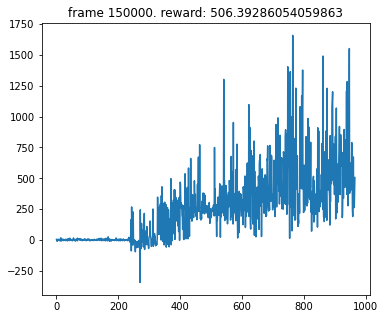

In [14]:
while frame_idx < max_frames:
    state = env.reset()
    episode_reward = 0
    
    for step in range(max_steps):
        if frame_idx > explore_before:
            action = policy.get_action(state).detach()
            next_state, reward, done, _ = env.step(action.numpy())
        else:
            action = env.action_space.sample()
            next_state, reward, done, _ = env.step(action)
        
        replay_buffer.push(state, action, reward, next_state, done)
        
        state = next_state
        episode_reward += reward
        frame_idx += 1
        
        if len(replay_buffer) > batch_size:
            update2(batch_size)
        
        if frame_idx % plot_idx == 0:
            plot(frame_idx, rewards)
        
        if done:
            break
        
    rewards.append(episode_reward)

Above are the SAC2 results for Walker2d. Below are SAC2 results for BipedalWalker.

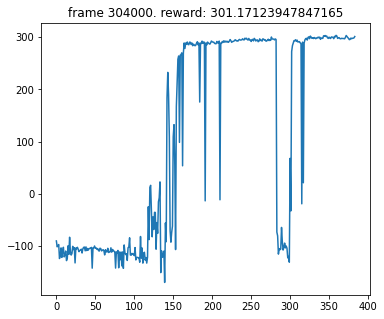